
## Animal Faces classification
This dataset, also known as Animal Faces-HQ (AFHQ), consists of 16,130 high-quality images at 512×512 resolution. 
Url of the dataset : https://www.kaggle.com/andrewmvd/animal-faces

Dataset description :
- number of images : 16,130
- Training size : 14630 images 
- they are 3 categories(classes) in this dataset (cat, dog, wild)
- val set size :1500 images  (cat, dog, wild)

- Image size : 512*512 pixels

In [25]:
#  loading required Librairies

import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

### animal-faces dataset
The dataset is extracted to the directory animal-faces. It contains 2 folders (train and val), containing the training set  (14630 images) with 3 classes and val set (14630) with 3 classes respectively.

In [26]:
# Import dataset

data_dir = '../input/animal-faces/afhq'
print('Folders :', os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print('3 classes :', classes)

Folders : ['train', 'val']
3 classes : ['wild', 'dog', 'cat']


In [27]:
dataset = ImageFolder(data_dir + '/train', transform=ToTensor())
print('Size of training Dataset :', len(dataset))

Size of training Dataset : 14630


In [28]:
val_ds = ImageFolder(data_dir + '/val', transform=ToTensor())
print('Size of val Dataset :', len(val_ds))

Size of val Dataset : 1500


Each element from the training dataset is a tuple, containing a image tensor and a label. Since the data consists of 512x512 pixel color images with 3 channels (RGB), each image tensor has the shape (3, 512, 512) :

In [29]:
img, label = dataset[0]
print(img.shape)

torch.Size([3, 512, 512])


Display of an image and its label using matplotlib :

Label:  cat (0)


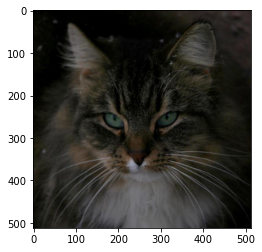

In [30]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))
    
show_example(*dataset[0])

Label:  wild (2)


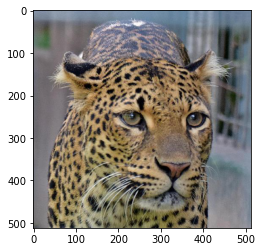

In [31]:
show_example(*dataset[10199])

### Preparing the data for training
The dataset is split into 3 parts :
- Training set : used to train the model i.e. compute the loss and adjust the weights of the model using gradient descent ;
- Validation set : used to evaluate the model while training, adjust hyperparameters (learning rate etc.) and pick the best version of the model ;
- Test set : used to compare different models, or different types of modeling approaches, and report the final accuracy of the model.
Since there's no predefined test set, we can set aside a small portion (5000 images) to be used as the test set. We'll use the random_split helper method from PyTorch to do this. To ensure that we always create the same test set, we'll also set a seed for the random number generator :

In [32]:
torch.manual_seed(43)
test_size = 5000
train_size = len(dataset) - test_size

In [33]:
train_ds, test = random_split(dataset, [train_size, test_size])
len(train_ds), len(test)

(9630, 5000)

We can now create data loaders for training and validation, to load the data in batches

In [34]:
batch_size = 20
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test, batch_size*2, num_workers=4, pin_memory=True)

We can look at batches of images from the dataset using the make_grid method from torchvision. Each time the following code is run, we get a different bach, since the sampler shuffles the indices before creating batches :

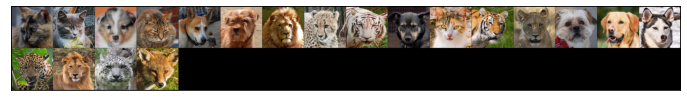

In [35]:
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

###  MY APPROACH: FEEDFORWARD NN


In [36]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [37]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [38]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Cheking if the GPU is available so we can move data into:

In [39]:
torch.cuda.is_available()

True

In [40]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [41]:
device = get_default_device()
device

device(type='cuda')

In [42]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [43]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

### Training the Model:


In [44]:
input_size = 3*512*512 # INPUT SIZE
output_size = 3 # Number of classes

In [45]:
class Model(ImageClassificationBase):
    def __init__(self, input_size, output_size):
        super().__init__()
        # hidden layer
        self.in_layer = nn.Linear(input_size, 64)
        self.hidden1 = nn.Linear(64, 256)
        self.hidden2 = nn.Linear(256, 512)
        self.hidden3 = nn.Linear(512, 1048)
        self.out_layer = nn.Linear(1048, output_size)
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        # Input layer
        out = self.in_layer(out)
        # Hidden layers w/ ReLU
        out = self.hidden1(F.relu(out))
        out = self.hidden2(F.relu(out))
        out = self.hidden3(F.relu(out))
        # Class output layer
        out = self.out_layer(F.relu(out))
        return out

In [46]:
model = to_device(Model(input_size, output_size), device)

In [47]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 1.0986032485961914, 'val_acc': 0.32894736528396606}]

we are having a accuracy of 32% before the model is trained

we gonna train the model and see if there is some improvements

We train the model using the fit function to reduce the validation loss & improve accuracy :

In [48]:
history += fit(8, 0.0001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.0881, val_acc: 0.3546
Epoch [1], val_loss: 1.0756, val_acc: 0.5289
Epoch [2], val_loss: 1.0603, val_acc: 0.4849
Epoch [3], val_loss: 1.0364, val_acc: 0.5487
Epoch [4], val_loss: 1.0054, val_acc: 0.5678
Epoch [5], val_loss: 0.9657, val_acc: 0.6217
Epoch [6], val_loss: 0.9227, val_acc: 0.6237
Epoch [7], val_loss: 0.8822, val_acc: 0.6145


In [ ]:
history += fit(3, 0.00001, model, train_loader, val_loader)

It seems like 0.0001 is a good learning rate so we better keep it this way

After 6 epoch we're getting a accuracy of 58% ,

In [2]:
history += fit(2, 0.0001, model, train_loader, val_loader)

In [ ]:
history += fit(4, 0.0001, model, train_loader, val_loader)

In [ ]:
history += fit(3, 0.0001, model, train_loader, val_loader)

It looks like the learning rate is becoming to big so let change it to 0.00001:

In [ ]:
history += fit(2, 0.00001, model, train_loader, val_loader)

In [ ]:
history += fit(3, 0.00001, model, train_loader, val_loader)

In [ ]:
history += fit(3, 0.0001, model, train_loader, val_loader)

If you want you can continue adjusting this model and see if you can get better result  approach and see if we could get better result.
Here we are getting 73% and its good! 

### Evaluating the model
We plot of the losses & accuracies and evaluate the first model on the test set :

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
plot_accuracies(history)

As you can see on the chart the accuracy on 72%-75% started to be stable

In [ ]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [ ]:
plot_losses(history)

loss reduced dramatically and started to be stable.

In [ ]:
evaluate(model, test_loader)

We get a prediction rate of 73.3%, knowing that there are 3 classes to predict, which is a good score.

-you can use CNN in the future to see if it could bring better result ,
-and the training step took a lot of time probably due to the image pixels(512px), which was huge to fit in the memory


In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
import jovian

In [ ]:
project_name = "animal faces classification"

In [ ]:
jovian.commit(project=project_name, environment=None, outputs=['animal face classf.pth'])